In [57]:
! pip install psycopg2-binary

import pandas as pd
import pandas.io.sql as sqlio
import psycopg2 as ps
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
#Init de la connexion à la db 
conn = ps.connect(
    host="54.36.191.217",
    port="5432",
    dbname="postgres",
    user="postgres",
    password="epsi-test-abc")

In [59]:
# Fetch des datas
pdf = sqlio.read_sql_query("SELECT fk_annee, taux_depenses, taux_recettes from mspr_ia.fait_taux", conn)
pdf = pdf.rename(columns={"fk_annee":"annees"})
pdf

C:\Users\allen\AppData\Local\Temp\ipykernel_19060\1895220478.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pdf = sqlio.read_sql_query("SELECT fk_annee, taux_depenses, taux_recettes from mspr_ia.fait_taux", conn)


annees  taux_depenses  taux_recettes
0     2023            NaN            NaN
1     2022      58.200000       53.50000
2     2021      59.057160       52.58313
3     2020      61.346756       52.36266
4     2019      55.400000       52.30000
..     ...            ...            ...
73    1950            NaN            NaN
74    1949            NaN            NaN
75    1948            NaN            NaN
76    1947            NaN            NaN
77    1946            NaN            NaN

[78 rows x 3 columns]

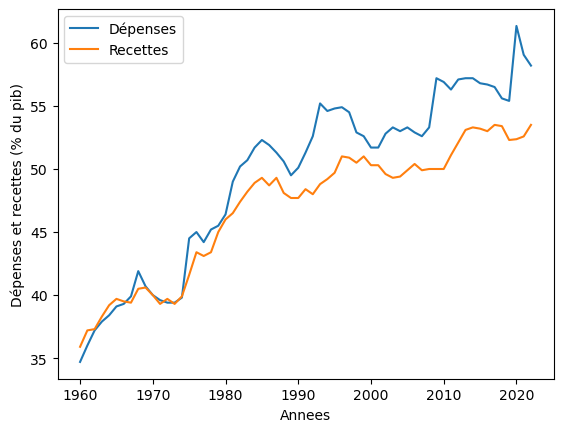

In [60]:
#Visualisation du df

x_data = pdf.annees
y_data1 = pdf.taux_depenses
y_data2 = pdf.taux_recettes

fig, ax = plt.subplots()
ax.plot(x_data, y_data1, label='Dépenses')
ax.plot(x_data, y_data2, label='Recettes')
ax.set_xlabel('Annees')
ax.set_ylabel('Dépenses et recettes (% du pib)')
ax.legend()
plt.show()

In [61]:
# Comme vu dans le rapport , on constate que les dépenses et les recettes de l'état ont presque doublées entre 1960 et 2022
# Cependant, l'écart entre ces deux indacateurs a également considérablement augmenté, indicatant le déficit de l'état par années

In [62]:
#Analyse statistique du dataset à la recherche d'oulayers
pdf.describe()

annees  taux_depenses  taux_recettes
count    78.000000      63.000000      63.000000
mean   1984.500000      49.538157      46.986441
std      22.660538       6.980726       5.156358
min    1946.000000      34.700000      35.900000
25%    1965.250000      44.350000      42.350000
50%    1984.500000      51.700000      48.900000
75%    2003.750000      54.850000      50.450000
max    2023.000000      61.346756      53.500000

In [63]:
# Les données statistiques semblent cohérentes et suivre la tendance d'augmentation des données au cours des années
# Cependant on peut voir que les années vont de 1946 à 2023 alors que le jue de données de dépenses et recettes ne concerne
# que les années 1960 à 2022

# Réduction du dataframe :
pdf = pdf[(pdf.annees >= 1960) & (pdf.annees <= 2022)]
pdf.describe()

annees  taux_depenses  taux_recettes
count    63.000000      63.000000      63.000000
mean   1991.000000      49.538157      46.986441
std      18.330303       6.980726       5.156358
min    1960.000000      34.700000      35.900000
25%    1975.500000      44.350000      42.350000
50%    1991.000000      51.700000      48.900000
75%    2006.500000      54.850000      50.450000
max    2022.000000      61.346756      53.500000

In [64]:
# Regression linéaire pour afin de mettre en relation les depenses et recette

# Recuperation du nombre de vote par annee du premier parti de notre echantillon

nb_votes_com = sqlio.read_sql_query("select \"FK_ANNEE\" as \"annees\", sum(nombre_de_votes) as \"nb_total_vote\", \"FK_PARTI\" as \"partis\" from mspr_ia.fait_vote where \"FK_PARTI\" = 'COM' group by \"FK_PARTI\", \"FK_ANNEE\" order by \"FK_ANNEE\"", conn)

nb_votes_com

C:\Users\allen\AppData\Local\Temp\ipykernel_19060\379667872.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  nb_votes_com = sqlio.read_sql_query("select \"FK_ANNEE\" as \"annees\", sum(nombre_de_votes) as \"nb_total_vote\", \"FK_PARTI\" as \"partis\" from mspr_ia.fait_vote where \"FK_PARTI\" = 'COM' group by \"FK_PARTI\", \"FK_ANNEE\" order by \"FK_ANNEE\"", conn)


annees  nb_total_vote partis
0     1958          90429    COM
1     1962          89129    COM
2     1967         119713    COM
3     1973         112165    COM
4     1978         122020    COM
5     1981          74453    COM
6     1988          54271    COM
7     1993          43948    COM
8     1997          54502    COM
9     2002          17170    COM
10    2007          25175    COM
11    2012            290    COM
12    2017          83259    COM
13    2022          83259    COM

In [65]:
# Jointure des deux dataframes
final_pdf_com = pd.merge(pdf, nb_votes_com, on="annees")
final_pdf_com

annees  taux_depenses  taux_recettes  nb_total_vote partis
0     2022           58.2           53.5          83259    COM
1     2017           56.5           53.5          83259    COM
2     2012           57.1           52.1            290    COM
3     2007           52.6           49.9          25175    COM
4     2002           52.8           49.6          17170    COM
5     1997           54.5           50.9          54502    COM
6     1993           55.2           48.8          43948    COM
7     1988           50.6           48.1          54271    COM
8     1981           49.0           46.5          74453    COM
9     1978           45.2           43.4         122020    COM
10    1973           39.4           39.3         112165    COM
11    1967           39.9           39.4         119713    COM
12    1962           37.2           37.3          89129    COM

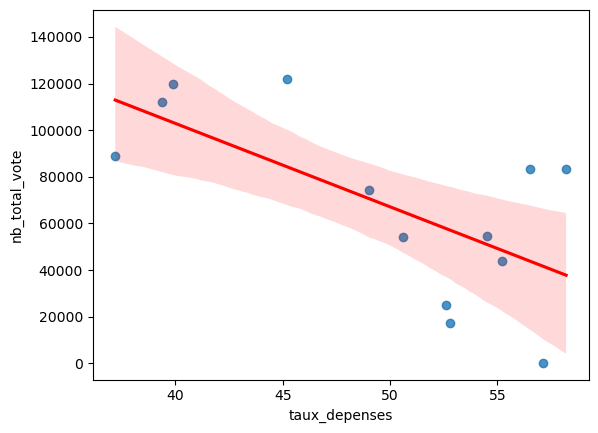

In [66]:
# Regression linéaire entre les depenses et les votes:

ax = sns.regplot(x="taux_depenses",y="nb_total_vote", data=final_pdf_com, line_kws={"color": "red"})

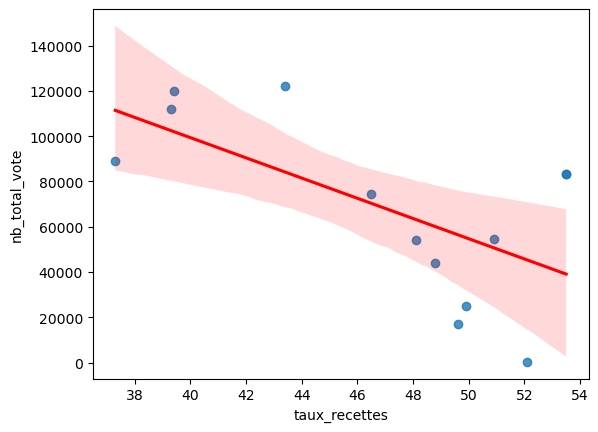

In [67]:
# Regression entre les recettes et les votes

ax = sns.regplot(x="taux_recettes",y="nb_total_vote", data=final_pdf_com, line_kws={"color": "red"})


In [68]:
# On peut constater ici une légère correlation entre notre variable Y (nombre de votes) et les recettes et depenses de l'état

# Selection d'un autre parti

nb_votes_exd = sqlio.read_sql_query("select \"FK_ANNEE\" as \"annees\", sum(nombre_de_votes) as \"nb_total_vote\", \"FK_PARTI\" as \"partis\" from mspr_ia.fait_vote where \"FK_PARTI\" = 'EXD' group by \"FK_PARTI\", \"FK_ANNEE\" order by \"FK_ANNEE\"", conn)

nb_votes_exd

C:\Users\allen\AppData\Local\Temp\ipykernel_19060\1842892358.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  nb_votes_exd = sqlio.read_sql_query("select \"FK_ANNEE\" as \"annees\", sum(nombre_de_votes) as \"nb_total_vote\", \"FK_PARTI\" as \"partis\" from mspr_ia.fait_vote where \"FK_PARTI\" = 'EXD' group by \"FK_PARTI\", \"FK_ANNEE\" order by \"FK_ANNEE\"", conn)


annees  nb_total_vote partis
0     1958           1621    EXD
1     1962              0    EXD
2     1967              0    EXD
3     1973           3880    EXD
4     1978           5760    EXD
5     1981           2981    EXD
6     1988            310    EXD
7     1993           1040    EXD
8     1997           2222    EXD
9     2002           7387    EXD
10    2007           1519    EXD
11    2017           1764    EXD
12    2022           1764    EXD

In [69]:
# Jointure des deux dataframes
final_pdf_exd = pd.merge(pdf, nb_votes_exd, on="annees")
final_pdf_exd

annees  taux_depenses  taux_recettes  nb_total_vote partis
0     2022           58.2           53.5           1764    EXD
1     2017           56.5           53.5           1764    EXD
2     2007           52.6           49.9           1519    EXD
3     2002           52.8           49.6           7387    EXD
4     1997           54.5           50.9           2222    EXD
5     1993           55.2           48.8           1040    EXD
6     1988           50.6           48.1            310    EXD
7     1981           49.0           46.5           2981    EXD
8     1978           45.2           43.4           5760    EXD
9     1973           39.4           39.3           3880    EXD
10    1967           39.9           39.4              0    EXD
11    1962           37.2           37.3              0    EXD

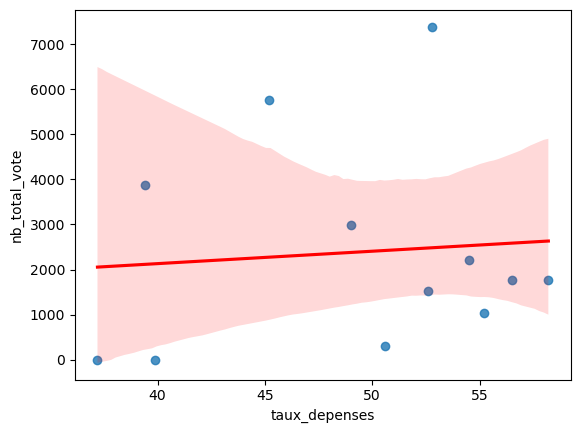

In [70]:
ax = sns.regplot(x="taux_depenses",y="nb_total_vote", data=final_pdf_exd, line_kws={"color": "red"})

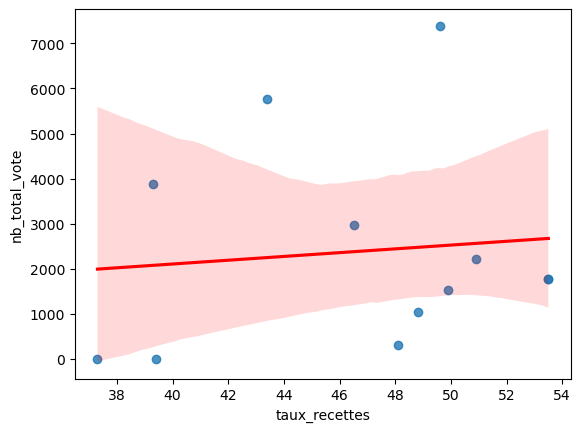

In [71]:
ax = sns.regplot(x="taux_recettes",y="nb_total_vote", data=final_pdf_exd, line_kws={"color": "red"})

In [72]:
# Dans le cas de l'extreme droite à l'inverse, la corrélation est innexistante entre nos Y et nos données de
# dépenses et recettes

# Passons à l'analyse pour les partis DIV

nb_votes_div = sqlio.read_sql_query("select \"FK_ANNEE\" as \"annees\", sum(nombre_de_votes) as \"nb_total_vote\", \"FK_PARTI\" as \"partis\" from mspr_ia.fait_vote where \"FK_PARTI\" = 'DIV' group by \"FK_PARTI\", \"FK_ANNEE\" order by \"FK_ANNEE\"", conn)
nb_votes_div

C:\Users\allen\AppData\Local\Temp\ipykernel_19060\3375398907.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  nb_votes_div = sqlio.read_sql_query("select \"FK_ANNEE\" as \"annees\", sum(nombre_de_votes) as \"nb_total_vote\", \"FK_PARTI\" as \"partis\" from mspr_ia.fait_vote where \"FK_PARTI\" = 'DIV' group by \"FK_PARTI\", \"FK_ANNEE\" order by \"FK_ANNEE\"", conn)


annees  nb_total_vote partis
0    1958           2235    DIV
1    1962           1121    DIV
2    1967              0    DIV
3    1993          16243    DIV
4    1997           6029    DIV
5    2002          16452    DIV
6    2007           3800    DIV
7    2012           1875    DIV
8    2017          57480    DIV
9    2022          57480    DIV

In [73]:
final_pdf_div = pd.merge(pdf, nb_votes_div, on="annees")
final_pdf_div

annees  taux_depenses  taux_recettes  nb_total_vote partis
0    2022           58.2           53.5          57480    DIV
1    2017           56.5           53.5          57480    DIV
2    2012           57.1           52.1           1875    DIV
3    2007           52.6           49.9           3800    DIV
4    2002           52.8           49.6          16452    DIV
5    1997           54.5           50.9           6029    DIV
6    1993           55.2           48.8          16243    DIV
7    1967           39.9           39.4              0    DIV
8    1962           37.2           37.3           1121    DIV

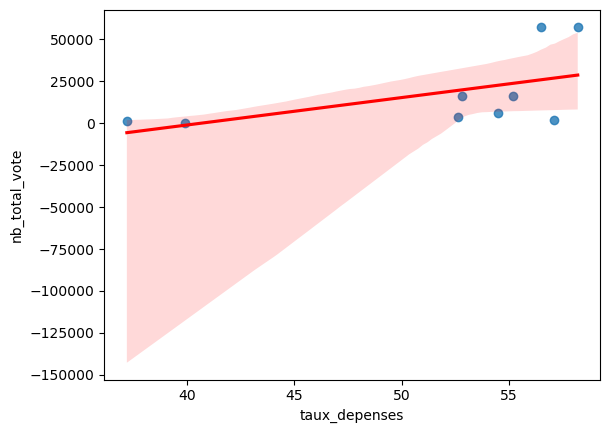

In [74]:
ax = sns.regplot(x="taux_depenses",y="nb_total_vote", data=final_pdf_div, line_kws={"color": "red"})


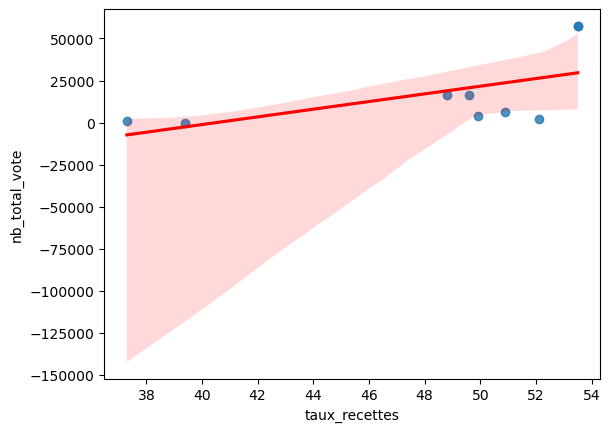

In [75]:
ax = sns.regplot(x="taux_recettes",y="nb_total_vote", data=final_pdf_div, line_kws={"color": "red"})


In [76]:
# Dans ce cas, une légère correlation peut etre observée meme si les valeurs restent très proche de 0